In [ ]:
!pip install transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
train_df = pd.read_csv('HateSpeechDetection_test_Clean.csv')
test_df = pd.read_csv('HateSpeechDetection_train_Clean.csv')


In [ ]:
print(train_df.head())
print(test_df.head())

                                              prompt  label
0              she is a filthy whore if she uses twt      1
1  That's just weird. I've never disliked someone...      0
2  Hes sky sports , the next season/team is alway...      0
3  Muslims kill babies with rocks because 'God to...      1
4            Black guy calling an asian a monkey Kek      1
                                              prompt  label
0  Do oils such as peppermint and rosemary cause ...      0
1  I hate niggers. Also yes you should have food ...      1
2  really good without the jacket, but I don’t li...      0
3  My fourth child is Type Tanoshimi. He's from a...      0
4  You might be the sweetest peach on the tree, b...      0


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# 加载GPT-2分词器
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # 使用eos_token作为padding

# 预处理函数
def preprocess_function(examples):
    return tokenizer(examples['prompt'], padding="max_length", truncation=True, max_length=128)

# 对训练和测试数据集进行预处理
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

# GPT2ForSequenceClassification 需要确保标签列命名为 'labels'
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

In [ ]:
# 加载GPT-2用于分类任务的模型
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)

# 将模型的pad_token_id设置为与分词器一致
model.config.pad_token_id = tokenizer.pad_token_id

# 将模型移动到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [ ]:
# 定义自定义评估函数
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=1)
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# 设置训练参数
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

In [ ]:
# 使用Trainer进行基准测试
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

In [ ]:
# 训练前进行基准测试
predictions_before_training = trainer.predict(tokenized_test)

In [ ]:
# 提取预测结果与真实标签
true_labels_pre = predictions_before_training.label_ids
predicted_labels_pre = predictions_before_training.predictions.argmax(-1)

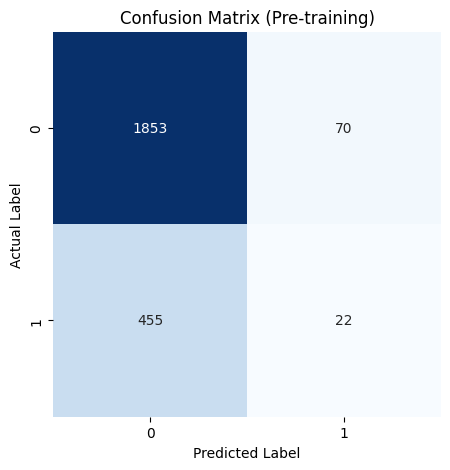

Before training predictions:
 {'test_loss': 0.5210329294204712, 'test_model_preparation_time': 0.0084, 'test_accuracy': 0.78125, 'test_precision': 0.2391304347826087, 'test_recall': 0.04612159329140461, 'test_f1': 0.07732864674868191, 'test_runtime': 1326.2397, 'test_samples_per_second': 1.81, 'test_steps_per_second': 0.226}


In [ ]:
# 绘制混淆矩阵
cm_pre = confusion_matrix(true_labels_pre, predicted_labels_pre)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_pre, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Pre-training)')
plt.show()

# 输出基准测试结果
print("Before training predictions:\n", predictions_before_training.metrics)

In [ ]:
# 开始训练模型
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.484400,0.411058,0.008400,0.815833,0.843137,0.090147,0.162879
2,0.336200,0.300129,0.008400,0.884167,0.906122,0.465409,0.614958
3,0.222300,0.267596,0.008400,0.900833,0.907850,0.557652,0.690909


TrainOutput(global_step=225, training_loss=0.34761094835069445, metrics={'train_runtime': 5948.3127, 'train_samples_per_second': 0.303, 'train_steps_per_second': 0.038, 'total_flos': 117583537766400.0, 'train_loss': 0.34761094835069445, 'epoch': 3.0})

In [ ]:
# 训练后评估模型
results = trainer.evaluate()


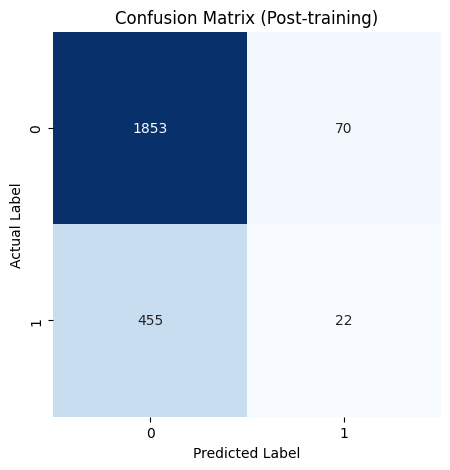

Evaluation results:
 {'eval_loss': 0.26759570837020874, 'eval_model_preparation_time': 0.0084, 'eval_accuracy': 0.9008333333333334, 'eval_precision': 0.9078498293515358, 'eval_recall': 0.5576519916142557, 'eval_f1': 0.6909090909090909, 'eval_runtime': 1039.8955, 'eval_samples_per_second': 2.308, 'eval_steps_per_second': 0.288, 'epoch': 3.0}


In [ ]:
# 提取混淆矩阵元素
cm = confusion_matrix(true_labels_pre, predicted_labels_pre)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Post-training)')
plt.show()

# 输出训练后的评估结果
print("Evaluation results:\n", results)

In [ ]:
# 进行推理
texts = ["I love programming.", "You are so stupid!"]

# 对输入文本进行Tokenization
inference_encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')

# 模型切换到评估模式
model.eval()

# 进行预测
with torch.no_grad():
    outputs = model(**inference_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

# 输出预测结果
labels = ['Non-Toxic', 'Toxic']
predicted_labels = [labels[pred] for pred in predictions]

for i, text in enumerate(texts):
    print(f"Text: {text}")
    print(f"Predicted Label: {predicted_labels[i]}\n")

Text: I love programming.
Predicted Label: Non-Toxic

Text: You are so stupid!
Predicted Label: Non-Toxic

